In [1]:
import logging

import graphcat.notebook

logging.basicConfig(level=logging.DEBUG)

In [2]:
def on_execute(sender, label, inputs):
    logging.debug(f"Executing '{label}'. Inputs: {inputs}")

In [3]:
class LoopBlock(object):
    def __init__(self, graph, iteration="loop-iteration", begin="loop-begin", end="loop-end", gather="loop-gather"):
        self._graph = graph
        self._iteration = iteration
        self._begin = begin
        self._end = end
        self._gather = gather
        
        graph.add_task(iteration)
        graph.add_task(begin, self.loop_begin)
        graph.add_task(end, self.loop_end)
        graph.add_task(gather, self.loop_gather)

        graph.add_relationship(end, gather, 0)
        
        self._iterating = False
        self._loop_output = []

    def loop_begin(self, label, inputs):
        if not self._iterating:
            self._iterating = True
            self._loop_output = []
            for i in range(3):
                logging.debug(f"Loop iteration {i}")
                self._graph.set_task_fn(self._iteration, graphcat.constant(i))
                self._graph.mark_unfinished(label)
                self._loop_output.append(self._graph.output(self._end))
            self._iterating = False
        return inputs.get(0, [None])[0]
        
    def loop_end(self, label, inputs):
        return inputs.get(0, [None])[0]
        
    def loop_gather(self, label, inputs):
        return self._loop_output


In [4]:
graph = graphcat.Graph()
#logger = graphcat.Logger(graph)
graph.on_execute.connect(on_execute);

DEBUG:root:Executing 'A'. Inputs: {}
DEBUG:root:Executing 'loop-begin'. Inputs: {0: ['foo']}
DEBUG:root:Loop iteration 0
DEBUG:root:Executing 'loop-begin'. Inputs: {0: ['foo']}
DEBUG:root:Executing 'B'. Inputs: {<Input.DEFAULT: 1>: ['foo']}
DEBUG:root:Executing 'loop-end'. Inputs: {0: ['bar']}
DEBUG:root:Loop iteration 1
DEBUG:root:Executing 'loop-begin'. Inputs: {0: ['foo']}
DEBUG:root:Executing 'B'. Inputs: {<Input.DEFAULT: 1>: ['foo']}
DEBUG:root:Executing 'loop-end'. Inputs: {0: ['bar']}
DEBUG:root:Loop iteration 2
DEBUG:root:Executing 'loop-begin'. Inputs: {0: ['foo']}
DEBUG:root:Executing 'B'. Inputs: {<Input.DEFAULT: 1>: ['foo']}
DEBUG:root:Executing 'loop-end'. Inputs: {0: ['bar']}
DEBUG:root:Executing 'loop-gather'. Inputs: {0: ['bar']}


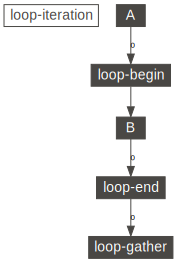

['bar', 'bar', 'bar']

In [5]:
loop = LoopBlock(graph)

graph.add_task("A", graphcat.constant("foo"))
graph.add_relationship("A", "loop-begin", 0)

graph.add_task("B", graphcat.constant("bar"))
graph.add_relationship("loop-begin", "B")
graph.add_relationship("B", "loop-end", 0)

graph.update("loop-gather")
graphcat.notebook.display(graph)
graph.output("loop-gather")